## 条件付きVAE

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

### データの前処理

In [ ]:
rng = np.random.RandomState(1234)
random_state = 42

batch_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
n_epochs = 20
CLASS_SIZE = 10

transform = transforms.Compose([
    # [0, 255] -> [0.0, 1.0]; (H, W, C) -> (C, H, W)
    # https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor
    transforms.ToTensor(), 
    # Flatten tensor
    transforms.Lambda(lambda x: x.view(-1))])

#Train, Valid用データローダーの作成
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

dataloader_valid = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



### モデルの定義

In [ ]:
def torch_log(x):  # torch.log(0)によるnanを防ぐ
    return torch.log(torch.clamp(x, min=1e-10))

In [ ]:
class CVAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self._in_nuits = 28*28
        hidden_units =512
        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.dense_enc1 = nn.Linear(self._in_nuits + CLASS_SIZE, hidden_units)
        self.dense_enc2 = nn.Linear(hidden_units, hidden_units)
        self.dense_encmean = nn.Linear(hidden_units, z_dim)
        self.dense_encvar = nn.Linear(hidden_units, z_dim)
        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Linear(z_dim + CLASS_SIZE, hidden_units)
        self.dense_dec2 = nn.Linear(hidden_units, hidden_units)
        self.dense_dec3 = nn.Linear(hidden_units, self._in_nuits)

    def _encoder(self, x):
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))
        return mean, std
    
    def encode(self, x, labels):
        in_ = torch.empty((x.shape[0], self._in_nuits + CLASS_SIZE), device=device)
        in_[:, :self._in_nuits] = x
        in_[:, self._in_nuits:] = labels
        return self._encoder(in_)

    def _sample_z(self, mean, std):
        #再パラメータ化トリック
        epsilon = torch.randn(mean.shape).to(device)
        return mean + std * epsilon
 
    def _decoder(self, z):
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(self.dense_dec3(x))
        return x

    def decode(self, z, labels):
        in_ = torch.empty((z.shape[0], self.z_dim + CLASS_SIZE), device=device)
        in_[:, :self.z_dim] = z
        in_[:, self.z_dim:] = labels
        return self._decoder(in_)

    def forward(self, x, labels):
        mean, std = self.encode(x, labels)
        z = self._sample_z(mean, std)
        x = self.decode(z, labels)
        return x, z

    def loss(self, x, labels):
        mean, std = self.encode(x, labels)
        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        # torch.sumは上式のJ(=z_dim)に関するもの. torch.meanはbatch_sizeに関するものなので,上式には書いてありません.
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))
    
        z = self._sample_z(mean, std)
        y = self.decode(z, labels)

        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 784)
        # torch.sumは上式のD(=784)に関するもの. torch.meanはbatch_sizeに関するもの.
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))
        
        return KL, -reconstruction 

In [ ]:
def to_onehot(label):
    return torch.eye(10, device=device, dtype=torch.float32)[label]

### 学習

In [ ]:
z_dim = 16
assert z_dim >= 2

model = CVAE(z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    num = 0
    
    model.train()
    for x, t in dataloader_train:
        num += 1
        print('\r%3d/600' % num, end='')

        x = x.to(device)
        t = to_onehot(t)

        model.zero_grad()

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x, t)  

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss 

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    print()
    losses_val = []
    model.eval()
    for x, t in dataloader_valid:

        x = x.to(device)
        t = to_onehot(t)

        KL_loss, reconstruction_loss = model.loss(x, t)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))

600/600
EPOCH: 1    Train Lower Bound: 161.907013 (KL_loss: 7.216318. reconstruction_loss: 154.690704)    Valid Lower Bound: 130.535782
600/600
EPOCH: 2    Train Lower Bound: 121.765587 (KL_loss: 12.143642. reconstruction_loss: 109.621925)    Valid Lower Bound: 117.888489
600/600
EPOCH: 3    Train Lower Bound: 112.792191 (KL_loss: 13.679351. reconstruction_loss: 99.112839)    Valid Lower Bound: 111.102013
600/600
EPOCH: 4    Train Lower Bound: 108.470703 (KL_loss: 14.155744. reconstruction_loss: 94.314964)    Valid Lower Bound: 107.653191
600/600
EPOCH: 5    Train Lower Bound: 105.910309 (KL_loss: 14.422393. reconstruction_loss: 91.487923)    Valid Lower Bound: 108.284836
600/600
EPOCH: 6    Train Lower Bound: 104.021317 (KL_loss: 14.587605. reconstruction_loss: 89.433708)    Valid Lower Bound: 105.592072
600/600
EPOCH: 7    Train Lower Bound: 102.775574 (KL_loss: 14.676477. reconstruction_loss: 88.099091)    Valid Lower Bound: 103.920143
600/600
EPOCH: 8    Train Lower Bound: 101.7426

### モデルの保存

In [ ]:
# Google DriveをColabにマウント
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

import os
work_dir = '/content/drive/MyDrive/masa/'
os.chdir(work_dir)

In [ ]:
torch.save(model.cpu().state_dict(), './cvae/cvae.pth')
model = model.to(device)

In [ ]:
model = CVAE(z_dim)
model.load_state_dict(torch.load('./cvae/cvae.pth'))
model = model.to(device)

### 結果

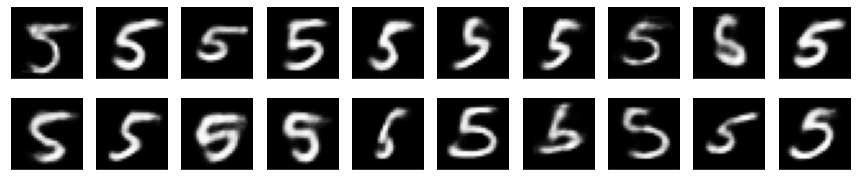

In [ ]:
label = 5

fig = plt.figure(figsize=(12, 3))
# fig.suptitle(f'Generation (label={label})', fontsize=10)

model.eval()
for i in range(20):
    # 標準正規分布からサイズ(1, z_dim)の乱数を生成
    z = torch.randn([1, z_dim]).to(device)
    # print(z)
    t = torch.tensor([label], device=device)
    y = model.decode(z, to_onehot(t))
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

[-0.00609687 -0.49504262 -0.54265296 -0.83338773 -0.7401099  -0.2750523
  0.77586985  0.07645822 -1.9724871  -0.11057357  0.01733868  0.00837758
 -0.6066699  -0.05390011  0.11858686  0.04161421]


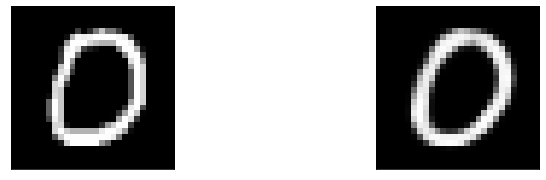

In [ ]:
fig = plt.figure(figsize=(12, 3))
num = 10

# num番目の画像を表示
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
x, t = valid_dataset[num]
im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().detach().numpy()

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(im, 'gray')

# num番目の画像の潜在変数の表示
model.eval()
x = x.to(device).unsqueeze(0) # [784] -> [1, 784]
t = to_onehot(t)
mean, std = model.encode(x, t)
print(mean.cpu().squeeze().detach().numpy())

# num番目の画像を再構成
y, z = model(x, t)
im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(im, 'gray')
plt.show()

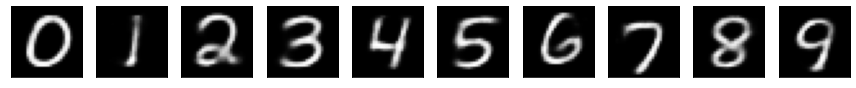

In [ ]:
fig = plt.figure(figsize=(12, 3))

# num番目の字体で1, 2,..を生成
model.eval()
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
x, t = valid_dataset[num]
x = x.to(device).unsqueeze(0)
t = to_onehot(t)
z, _ = model.encode(x, t)

for label in range(CLASS_SIZE):
    t = torch.tensor([label], device=device)
    y = model.decode(z, to_onehot(t))
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(1, 10, label+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
    